# Data Processing and Analytics Project: NYC Taxis
The goal of the project is to write spark programs to conduct queries on a taxi drives database for the following:
- utilization per taxi / driver,
- average time it takes for a taxi to find its next fare,
- the number of trips that started and ended within the same borough or started in one borough and ended in another one.

### Teammates:
- Lovato Edoardo 12515068
- Markhovski Julia 12514030
- Piccoli Leonardo Arduino 12515079

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, functions as F, types as T, Window as W

# Imports for data visualization
import os, math, itertools, numpy as np, pandas as pd, matplotlib.pyplot as plt

conf = SparkConf().setMaster("local").setAppName("Spark Test")
sc = SparkContext(conf=conf)

DATA_DIR = "../data"
CSV_PATH = os.path.join(DATA_DIR, "Sample NYC Data.csv")
JSON_PATH = os.path.join(DATA_DIR, "nyc-boroughs.geojson.json")

spark = SparkSession.builder.appName("NYC taxis").getOrCreate()

# Taxi drives dataframe
taxiDF = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .csv(CSV_PATH))

# Boroughs dataframe
jsonDF = (spark.read
    .option("header", True)
    .option("inferSchema", True)
    .option("multiLine", True)
    .json(JSON_PATH))

## Exploratory Data Analysis (EDA)
We begin by loading the dataset and doing the exploratory data analysis (EDA) to gain an understanding of the underlying data.

In [2]:
print("Rows:", taxiDF.count(),"\n")
taxiDF.printSchema()
taxiDF.show(5, truncate=False)

DF = taxiDF

Rows: 99999 

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)

+--------------------------------+--------------------------------+---------+---------+------------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+
|medallion                       |hack_license                    |vendor_id|rate_code|store_and_fwd_flag|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitu

We look at the percentage of missing values and the cardinality for each column.

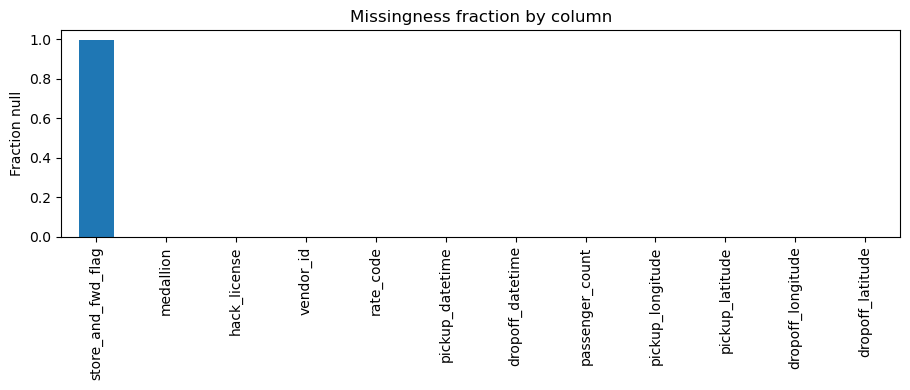

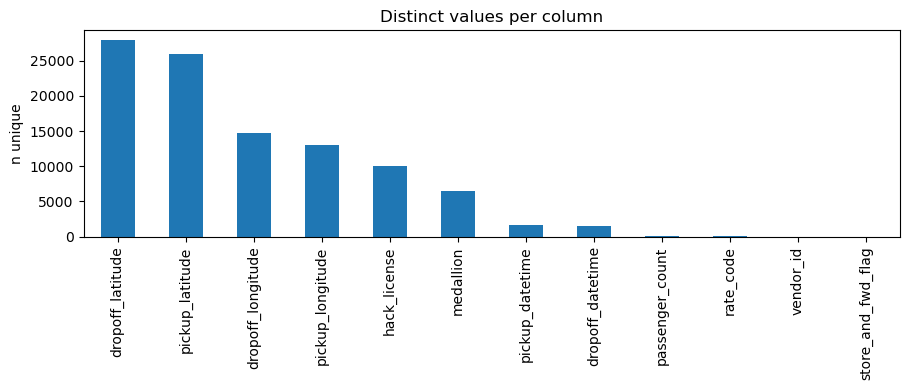

In [3]:
# Missingness fraction per column
miss_exprs = [F.mean(F.col(c).isNull().cast("double")).alias(c) for c in DF.columns]
missing_row = DF.select(miss_exprs).collect()[0].asDict()
missing_ser = pd.Series(missing_row).sort_values(ascending=False)

plt.figure(figsize=(min(16, 0.35*len(missing_ser)+5), 4))
missing_ser.plot(kind="bar")
plt.title("Missingness fraction by column"); plt.ylabel("Fraction null"); plt.tight_layout(); plt.show()

# Distinct counts (cardinality)
card_exprs = [F.countDistinct(F.col(c)).alias(c) for c in DF.columns]
card_row = DF.agg(*card_exprs).collect()[0].asDict()
card_ser = pd.Series(card_row).sort_values(ascending=False)

plt.figure(figsize=(min(16, 0.35*len(card_ser)+5), 4))
card_ser.plot(kind="bar")
plt.title("Distinct values per column"); plt.ylabel("n unique"); plt.tight_layout(); plt.show()


Next, we perform descriptive statistics on the dataset.

In [4]:
# Type detection
def spark_is_numeric(dt):
    return isinstance(dt, (T.ByteType, T.ShortType, T.IntegerType, T.LongType, T.FloatType, T.DoubleType, T.DecimalType))

def spark_is_string(dt):
    return isinstance(dt, T.StringType)

def spark_is_bool(dt):
    return isinstance(dt, T.BooleanType)

def spark_is_datetime(dt):
    return isinstance(dt, (T.TimestampType, T.DateType))

schema = {f.name: f.dataType for f in DF.schema.fields}

num_cols = [c for c,t in schema.items() if spark_is_numeric(t)]
str_cols = [c for c,t in schema.items() if spark_is_string(t)]
bool_cols = [c for c,t in schema.items() if spark_is_bool(t)]
dt_cols  = [c for c,t in schema.items() if spark_is_datetime(t)]

# Geo heuristics (common NYC taxi naming)
def find_first(cols, include_all, must_have):
    for c in cols:
        s = c.lower()
        if all(k in s for k in include_all) and all(k in s for k in must_have):
            return c
    return None

pu_lon = find_first(schema.keys(), ["pickup"], ["lon"]) or find_first(schema.keys(), ["pickup"], ["longitude"])
pu_lat = find_first(schema.keys(), ["pickup"], ["lat"]) or find_first(schema.keys(), ["pickup"], ["latitude"])
do_lon = find_first(schema.keys(), ["drop"],   ["lon"]) or find_first(schema.keys(), ["drop"],   ["longitude"])
do_lat = find_first(schema.keys(), ["drop"],   ["lat"]) or find_first(schema.keys(), ["drop"],   ["latitude"])

# Plotting config
MAX_ROWS_PLOT = 40_000   # cap pandas sample size for plotting
TOP_K_CATS     = 30      # max categories in per-column bar plots
BINS_NUMERIC   = 50

In [5]:
# Numeric summary
rows = []
quantiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
for c in num_cols:
    stats = DF.select(
        F.count(F.col(c)).alias("count"),
        F.mean(F.col(c)).alias("mean"),
        F.stddev(F.col(c)).alias("std"),
        F.min(F.col(c)).alias("min"),
        F.max(F.col(c)).alias("max"),
        F.sum((F.col(c)==0).cast("int")).alias("zeros"),
        F.sum((F.col(c)<0).cast("int")).alias("negatives")
    ).collect()[0].asDict()
    try:
        qs = DF.approxQuantile(c, quantiles, 0.01)
    except Exception:
        qs = [None]*len(quantiles)
    rows.append({
        "column": c, **stats,
        "q01": qs[0], "q05": qs[1], "q25": qs[2], "q50": qs[3],
        "q75": qs[4], "q95": qs[5], "q99": qs[6]
    })

num_summary_pdf = pd.DataFrame(rows).set_index("column").sort_index()
display(num_summary_pdf)


,count,mean,std,min,max,zeros,negatives,q01,q05,q25,q50,q75,q95,q99
column,,,,,,,,,,,,,,
dropoff_latitude,99999,39.922430,14.806523,-3113.788800,652.72314,1901,2,-3113.788800,40.692448,40.736450,40.755222,40.769623,40.792145,652.72314
dropoff_longitude,99999,-72.553158,10.154353,-95.650002,0.00000,1917,98082,-95.650002,-74.005402,-73.991348,-73.980804,-73.963890,-73.870720,0.00000
passenger_count,99999,2.163002,1.739888,0.000000,6.00000,1,0,0.000000,1.000000,1.000000,1.000000,3.000000,6.000000,6.00000
pickup_latitude,99999,40.048643,5.795548,0.000000,646.43829,1749,0,0.000000,40.675812,40.735104,40.755291,40.769539,40.790394,646.43829
pickup_longitude,99999,-72.655734,9.784012,-98.116669,0.00000,1770,98229,-98.116669,-74.005600,-73.991867,-73.980858,-73.964722,-73.870750,0.00000
rate_code,99999,1.042100,0.285498,1.000000,5.00000,0,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.00000


In [6]:
# Pandas sample for plotting
plot_cols = list(dict.fromkeys(num_cols + str_cols + bool_cols + dt_cols + [x for x in [pu_lon, pu_lat, do_lon, do_lat] if x]))
pdf = DF.select(*plot_cols).limit(MAX_ROWS_PLOT).toPandas()
print(pdf.shape)
pdf.head()

(40000, 12)


,rate_code,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,medallion,hack_license,vendor_id,store_and_fwd_flag,pickup_datetime,dropoff_datetime
0,1,4,-73.978165,40.757977,-73.989838,40.751171,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,N,01-01-13 15:11,01-01-13 15:18
1,1,1,-74.006683,40.731781,-73.994499,40.750660,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,N,06-01-13 00:18,06-01-13 00:22
2,1,1,-74.004707,40.737770,-74.009834,40.726002,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,N,05-01-13 18:49,05-01-13 18:54
3,1,2,-73.974602,40.759945,-73.984734,40.759388,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,N,07-01-13 23:54,07-01-13 23:58
4,1,1,-73.976250,40.748528,-74.002586,40.747868,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,N,07-01-13 23:25,07-01-13 23:34


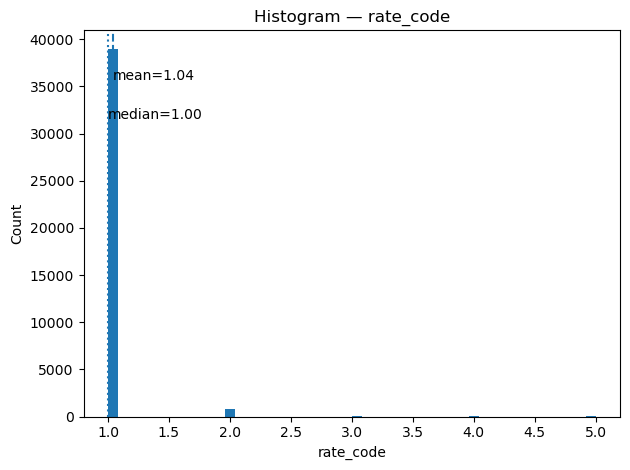

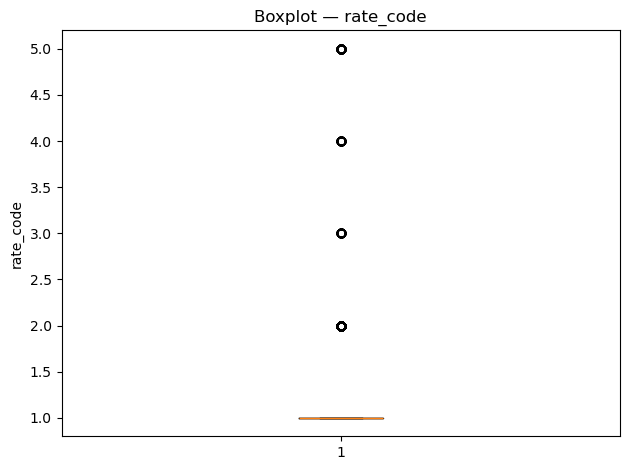

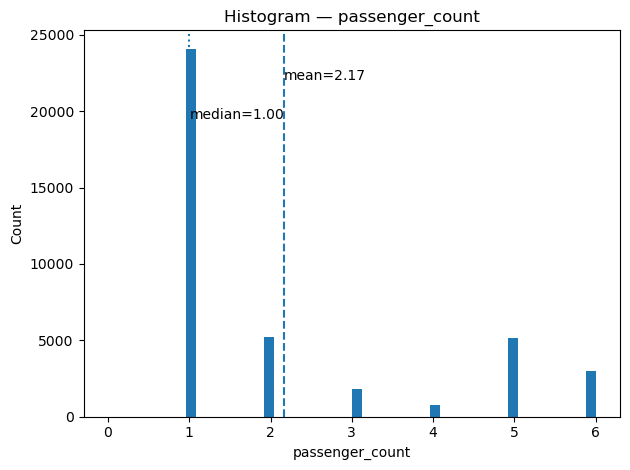

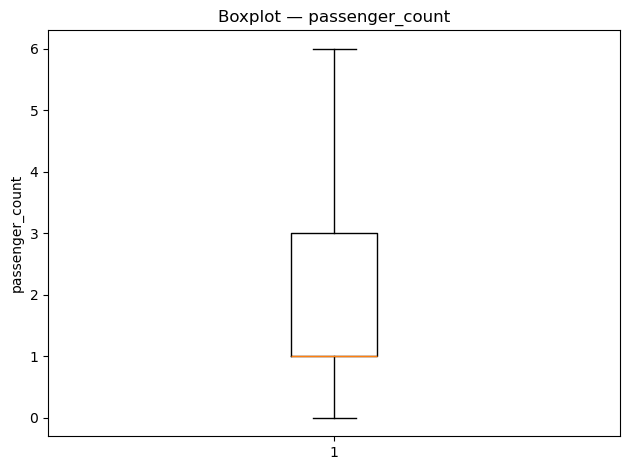

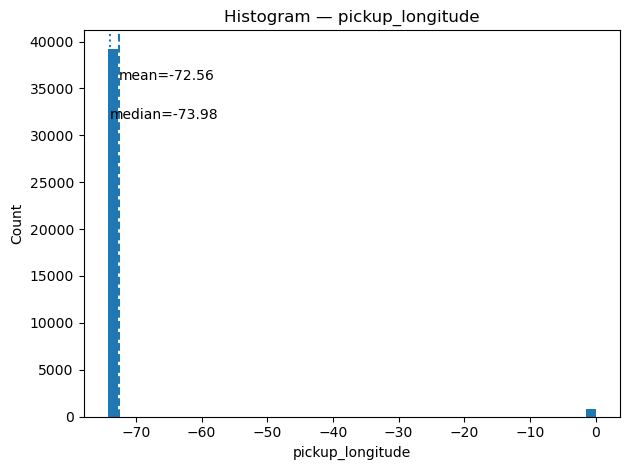

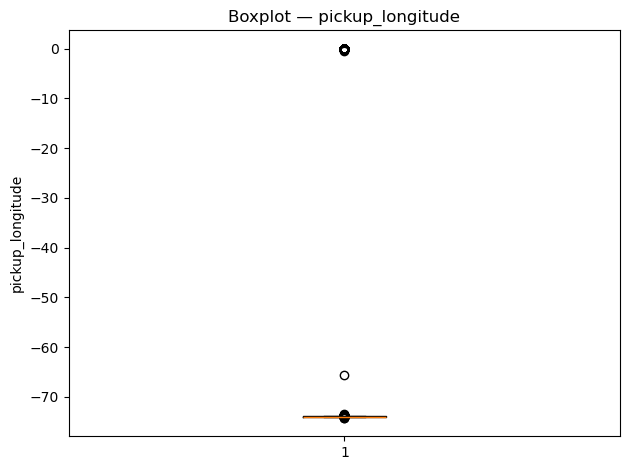

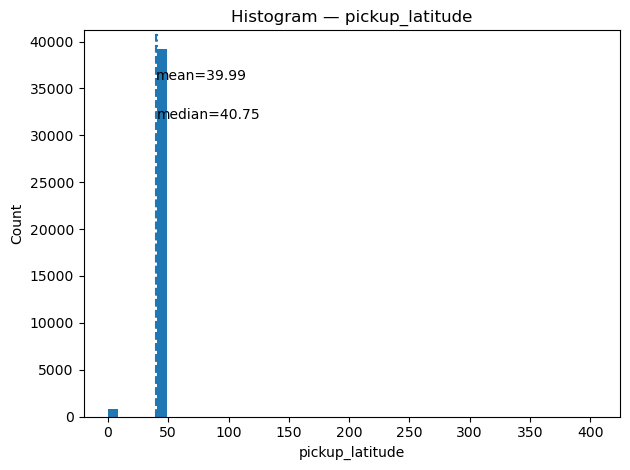

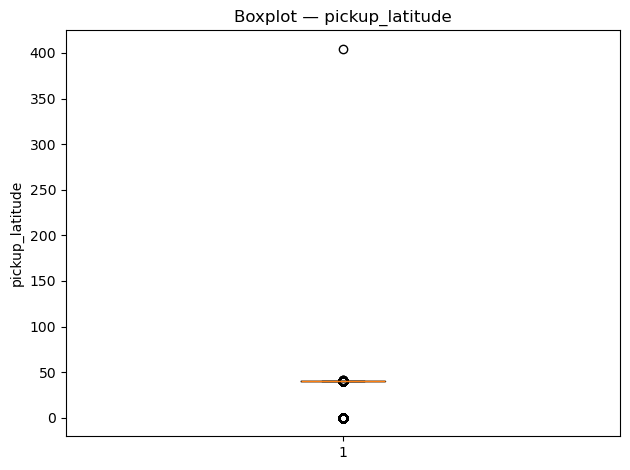

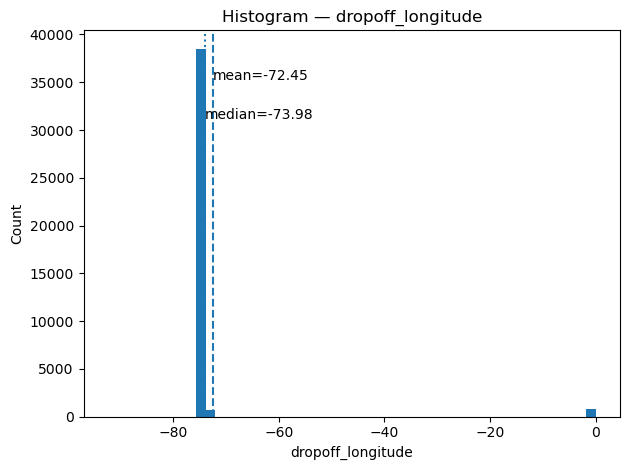

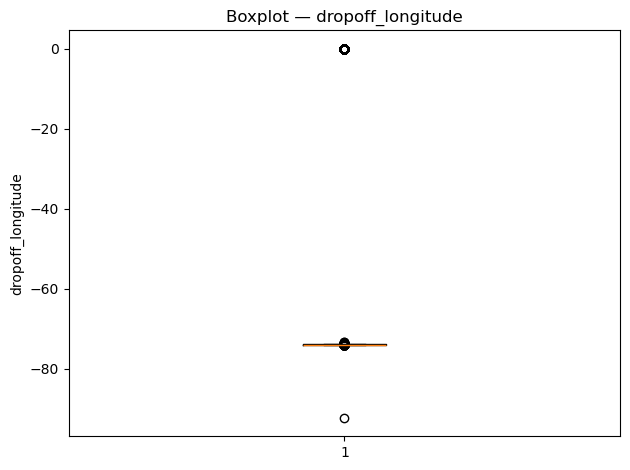

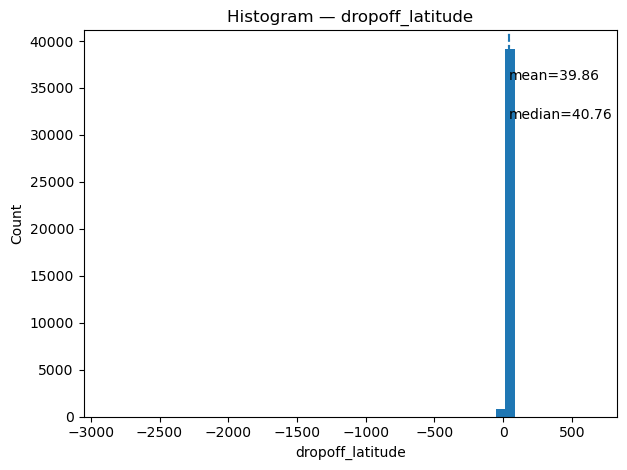

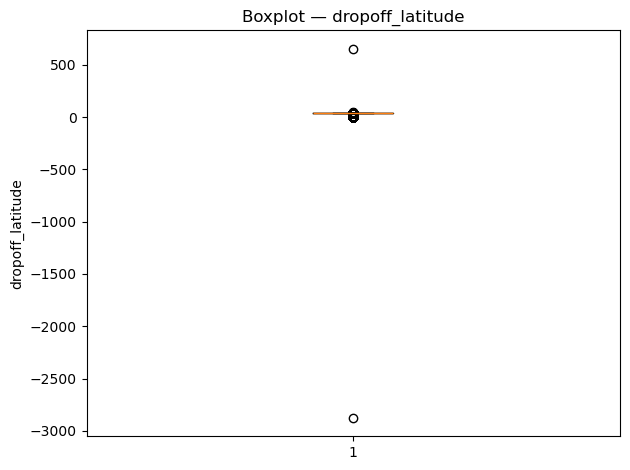

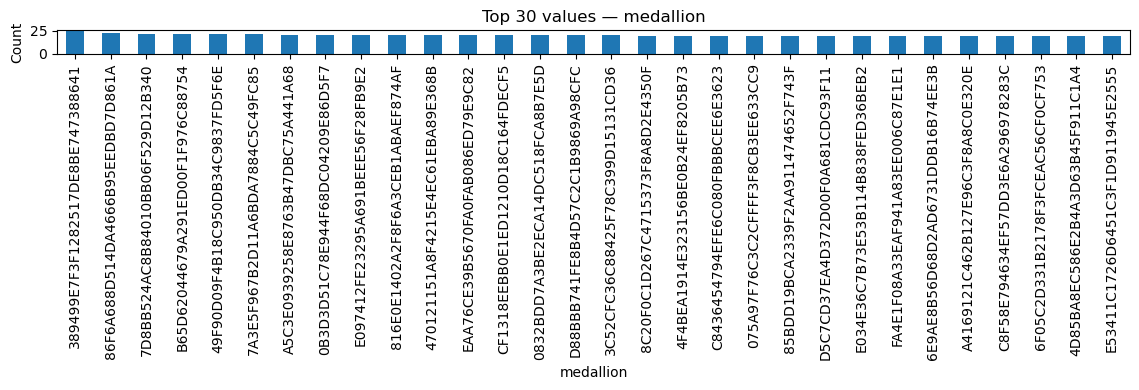

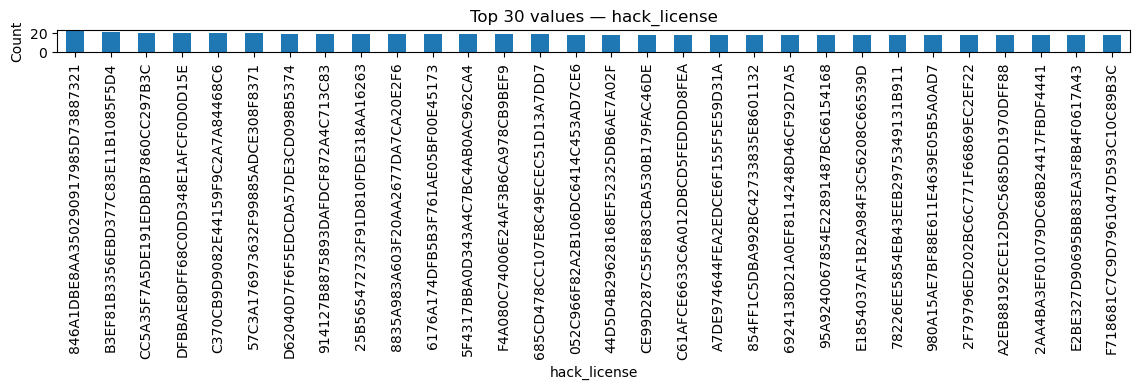

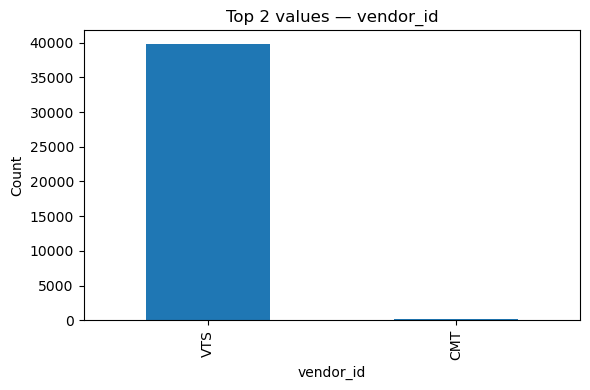

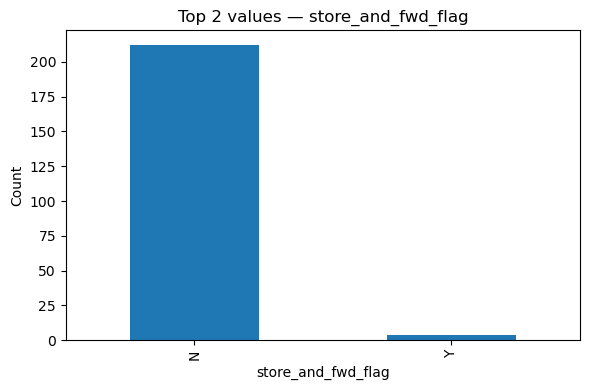

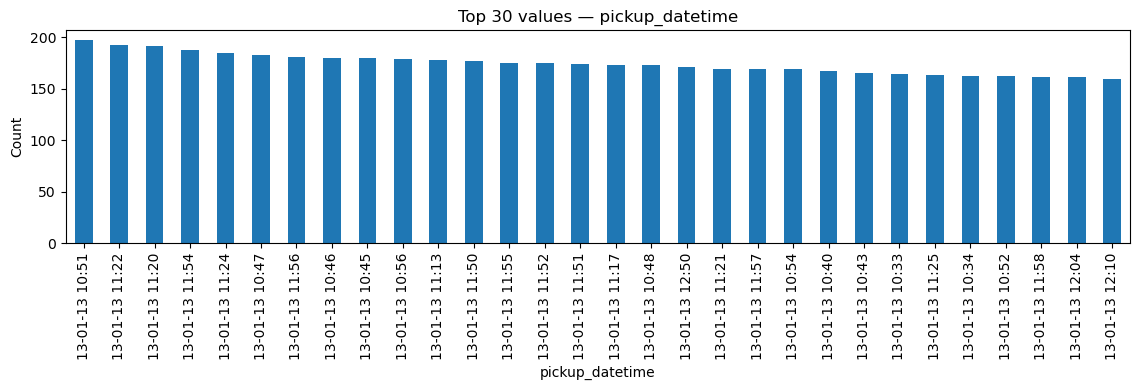

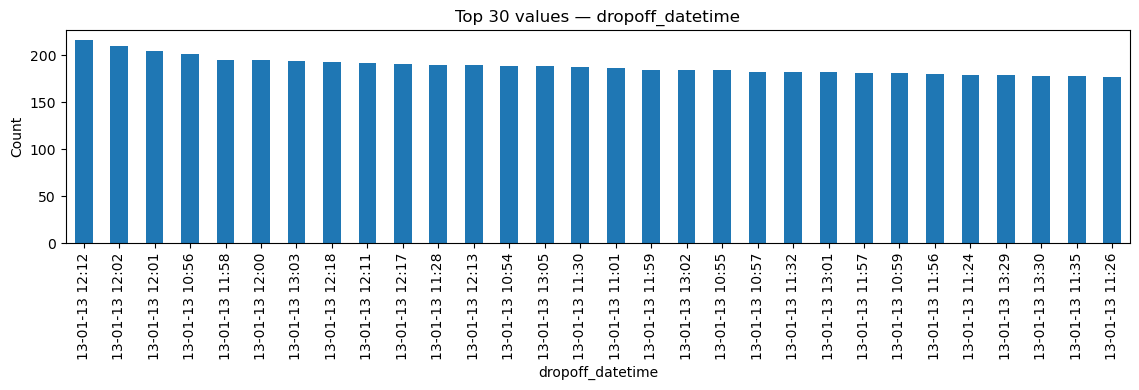

In [7]:
# Univariate plots

# Numeric: histogram + boxplot (separate figures)
for c in num_cols:
    x = pd.to_numeric(pdf[c], errors="coerce").dropna()
    if x.empty: 
        continue
    # histogram
    plt.figure()
    plt.hist(x.values, bins=BINS_NUMERIC)
    plt.title(f"Histogram — {c}")
    plt.xlabel(c); plt.ylabel("Count")
    # mean/median lines
    m, med = x.mean(), x.median()
    ylim = plt.gca().get_ylim()[1]
    plt.axvline(m, linestyle="--"); plt.text(m, 0.9*ylim, f"mean={m:.2f}", rotation=0, va="top")
    plt.axvline(med, linestyle=":"); plt.text(med, 0.8*ylim, f"median={med:.2f}", rotation=0, va="top")
    plt.tight_layout(); plt.show()

    # boxplot
    plt.figure()
    plt.boxplot(x.values, vert=True, showfliers=True)
    plt.title(f"Boxplot — {c}"); plt.ylabel(c)
    plt.tight_layout(); plt.show()

# Categorical / boolean: bar of top-k
for c in str_cols + bool_cols:
    vc = pdf[c].astype("string").value_counts(dropna=True).head(TOP_K_CATS)
    if vc.empty: 
        continue
    plt.figure(figsize=(max(6, 0.25*len(vc)+4), 4))
    vc.plot(kind="bar")
    plt.title(f"Top {min(TOP_K_CATS, len(vc))} values — {c}")
    plt.xlabel(c); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

# Datetime: by hour-of-day and day-of-week
for c in dt_cols:
    s = pd.to_datetime(pdf[c], errors="coerce").dropna()
    if s.empty: 
        continue
    # hour
    plt.figure()
    s.dt.hour.value_counts().sort_index().plot(kind="bar")
    plt.title(f"Distribution by hour — {c}")
    plt.xlabel("Hour"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()
    # day of week
    plt.figure()
    order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    s.dt.day_name().value_counts().reindex(order).plot(kind="bar")
    plt.title(f"Distribution by day of week — {c}")
    plt.xlabel("Day"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()


After the descriptive statistics, we look at the relationship between the columns by printing a correlation matrix.

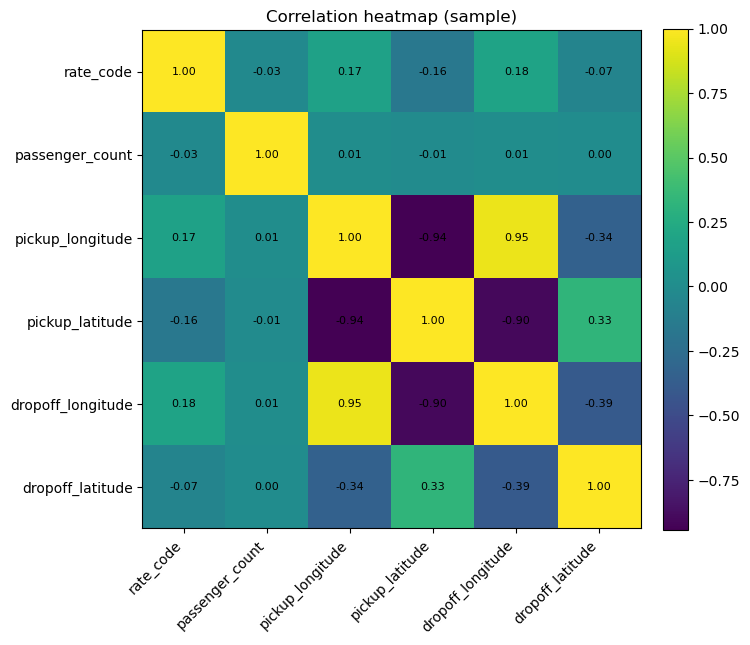

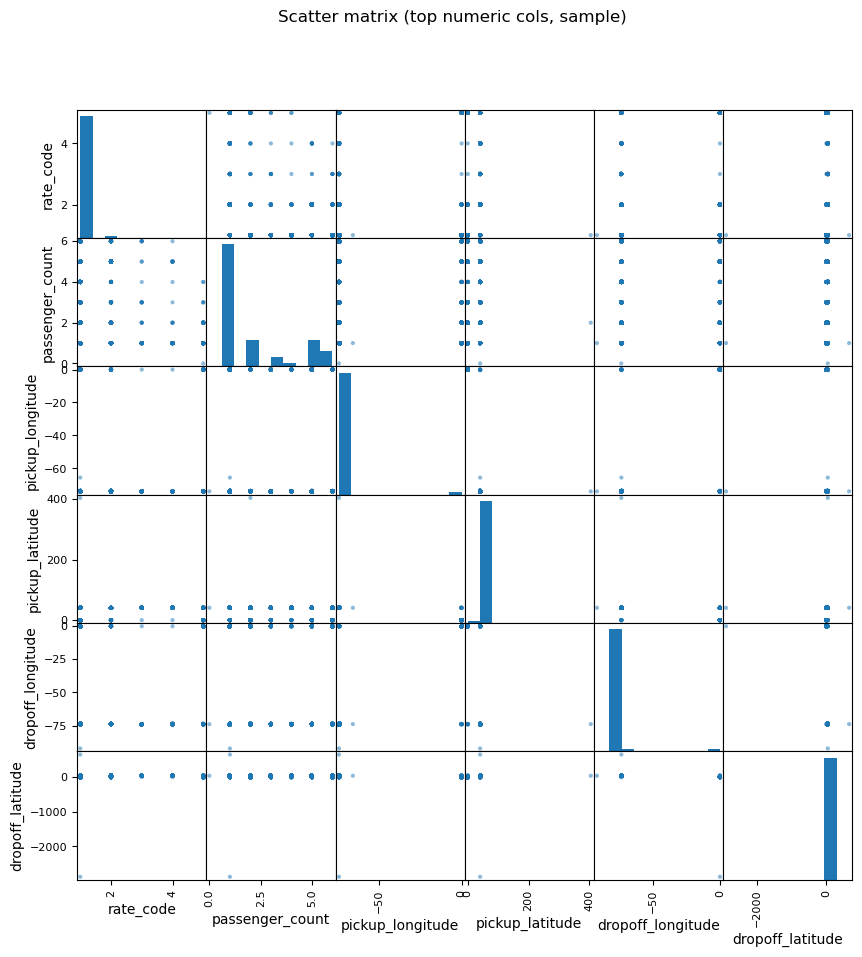

In [8]:
# Correlation heatmap (numeric)

if len(num_cols) >= 2:
    corr = pdf[num_cols].apply(pd.to_numeric, errors="coerce").corr()
    plt.figure(figsize=(min(14, 0.6*len(num_cols)+4), min(12, 0.6*len(num_cols)+4)))
    im = plt.imshow(corr.values, interpolation="nearest")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation heatmap (sample)")

    for i in range(len(num_cols)):
        for j in range(len(num_cols)):
            plt.text(j, i, f"{corr.values[i,j]:.2f}", ha="center", va="center", fontsize=8)
    plt.tight_layout(); plt.show()

# Scatter-matrix for top numeric columns
from pandas.plotting import scatter_matrix
top_num = num_cols[:6]  # cap to keep plots readable
if len(top_num) >= 2:
    scatter_matrix(pdf[top_num].apply(pd.to_numeric, errors="coerce"), diagonal='hist', figsize=(10,10))
    plt.suptitle("Scatter matrix (top numeric cols, sample)")
    plt.show()


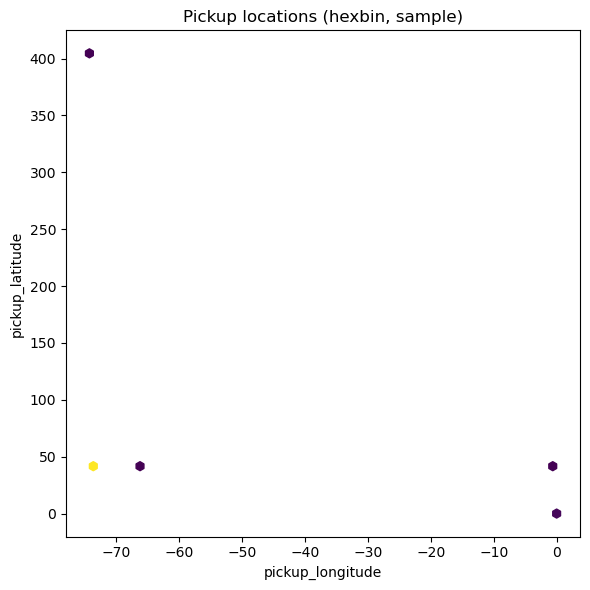

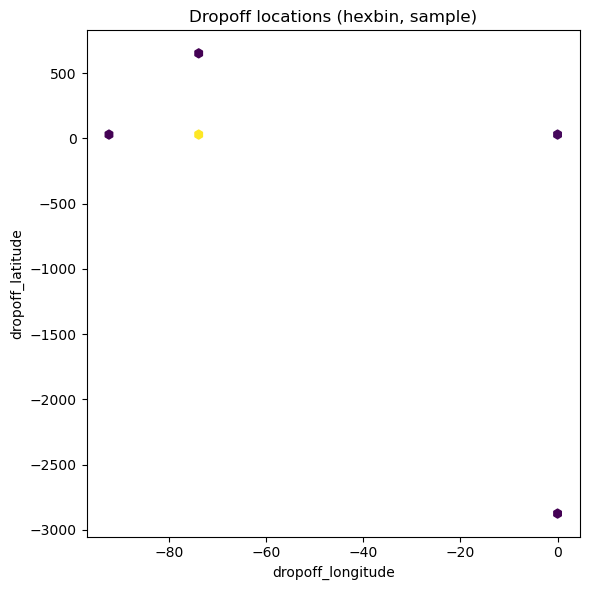

In [9]:
# Geo hexbins
def hex_scatter(df, xcol, ycol, title):
    arr = df[[xcol, ycol]].astype(float).dropna()
    if arr.empty: return
    plt.figure(figsize=(6,6))
    plt.hexbin(arr[xcol], arr[ycol], gridsize=60, mincnt=1)
    plt.title(title); plt.xlabel(xcol); plt.ylabel(ycol)
    plt.tight_layout(); plt.show()

if pu_lon and pu_lat and pu_lon in pdf.columns and pu_lat in pdf.columns:
    hex_scatter(pdf, pu_lon, pu_lat, "Pickup locations (hexbin, sample)")
if do_lon and do_lat and do_lon in pdf.columns and do_lat in pdf.columns:
    hex_scatter(pdf, do_lon, do_lat, "Dropoff locations (hexbin, sample)")


Points to consider for data cleaning:

Missingness & cardinality → decide which columns to drop/impute or downcast.

Numeric summary (quantiles, zeros, negatives) → spot outliers (e.g., negative distances/durations).

Datetime distributions → identify weird time ranges.

Correlations, scatter matrix → detect redundant columns or suspicious relationships.

Geo hexbin → quickly see coordinate errors (points far outside NYC).

Check that passenger amount is always a whole number.

Check if there is no pickup or no dropoff.

## Building Map from Data
From the GeoJson file, we only take the meaningful shapes identified by the highest number of points (couple of coordinates), given the same borough ID.

In [10]:
from shapely.geometry import shape
from shapely.geometry import Polygon

print("Rows:", jsonDF.count(),"\n")
jsonDF.printSchema()

# Explode the file hierarchy
resultJsonDF = jsonDF.selectExpr("explode(features) as feature").withColumn("num_points", F.size( F.flatten(F.flatten(F.col("feature.geometry.coordinates"))) ))

resultJsonDF = (resultJsonDF.select(
        F.col("feature.properties.borough").alias("borough"),
        F.col("feature.properties.boroughCode").alias("borough_code"),
        F.col("feature.geometry.coordinates").alias("coordinates"),
        F.col("num_points")
    )
)

# Group by (borough, borough_code), order by num_points
w = W.partitionBy("borough", "borough_code").orderBy(F.desc("num_points"))

finalJsonDF = (resultJsonDF
    .withColumn("rk", F.row_number().over(w))
    .where(F.col("rk") == 1)
    .drop("rk")
    .orderBy(F.desc("num_points"))
)

print("Selected boroughs from the file:")
finalJsonDF.show()

Rows: 1 

root
 |-- features: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- geometry: struct (nullable = true)
 |    |    |    |-- coordinates: array (nullable = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |    |-- type: string (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- properties: struct (nullable = true)
 |    |    |    |-- @id: string (nullable = true)
 |    |    |    |-- borough: string (nullable = true)
 |    |    |    |-- boroughCode: long (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- type: string (nullable = true)

Selected boroughs from the file:
+-------------+------------+--------------------+----------+
|      borough|borough_code|         coordinates|num_points|
+-------------+------------+------------------

In [11]:
# Save only the boroughs with the most points
trueBoroughs = list()

rows = finalJsonDF.collect()

for r in rows:
    polygon = shape({"type": "Polygon", "coordinates": r[2]})
    borough = [r[1], r[0], polygon]
    trueBoroughs.append(borough)

trueBoroughs.sort()

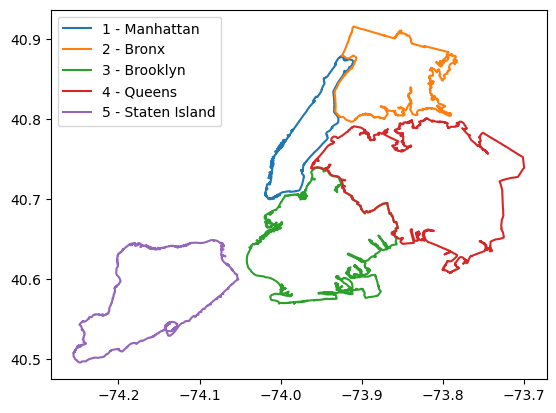

X bounds: [ -74.25559136315215 , -73.70002020503293 ]
Y bounds: [ 40.4961339876118 , 40.91553277700519 ]


In [12]:
# Plot the polygons
mapNY = list()

# Coordinates max/min bounds
MAX_X = -999
MAX_Y = -999
MIN_X = 999
MIN_Y = 999

# Create a plot (only for visualization)
for poly in trueBoroughs:
    mapNY.append(plt.plot(*poly[2].exterior.xy, label=str(poly[0])+" - "+str(poly[1])))

    if(poly[2].bounds[0] < MIN_X):
        MIN_X = poly[2].bounds[0]
    if(poly[2].bounds[1] < MIN_Y):
        MIN_Y = poly[2].bounds[1]
    if(poly[2].bounds[2] > MAX_X):
        MAX_X = poly[2].bounds[2]
    if(poly[2].bounds[3] > MAX_Y):
        MAX_Y = poly[2].bounds[3]

plt.legend(loc="upper left")
plt.show()
print("X bounds: [",MIN_X, ",", MAX_X, "]")
print("Y bounds: [",MIN_Y, ",", MAX_Y, "]")

## Data Cleaning

DataFrame / TEMP VIEW:
This just changes what the current notebook session sees. We create a new DataFrame (or temp view) without those columns, but the files on the disk do not change. When the notebook is restarted, one needs to run the same projection again. We opt for this since the source is a stable folder of a CSV file.

### Useless Columns

In [13]:
# Drop the three columns (keeps files on disk unchanged)
colsToDrop = ["vendor_id", "rate_code", "store_and_fwd_flag"]
existing = [c for c in colsToDrop if c in taxiDF.columns]
taxiDF = taxiDF.drop(*existing)

print("Columns after drop:\n", taxiDF.columns)

Columns after drop:
 ['medallion', 'hack_license', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']


### Passeger Count

In [14]:
# Audit passenger_count before filtering
passCount = F.col("passenger_count")
passCount_D = passCount.cast("double")  # robust audit even if the column is string

auditBefore = (taxiDF.select(
        F.count("*").alias("total_rows"),
        F.sum(passCount.isNull().cast("int")).alias("null_original"),
        F.sum(passCount_D.isNull().cast("int")).alias("non_numeric_or_null_after_cast"),
        F.sum((passCount_D <= 0).cast("int")).alias("non_positive"),
        F.sum((F.floor(passCount_D) != passCount_D).cast("int")).alias("fractional")
    )
)
print("Before:")
auditBefore.show(truncate=False)

# Distribution peeks
(taxiDF
 .groupBy(passCount)
 .count()
 .orderBy(passCount)
 .show(50, truncate=False))

# Keep only passenger_count > 0
taxiDF = taxiDF.filter(passCount > 0)

# Verify cleanup
auditAfter = (taxiDF.select(
        F.count("*").alias("total_rows"),
        F.sum(passCount.isNull().cast("int")).alias("null_passenger_count"),
        F.sum((passCount <= 0).cast("int")).alias("non_positive_passenger_count")
    )
)

print("After:")
auditAfter.show(truncate=False)

Before:
+----------+-------------+------------------------------+------------+----------+
|total_rows|null_original|non_numeric_or_null_after_cast|non_positive|fractional|
+----------+-------------+------------------------------+------------+----------+
|99999     |0            |0                             |1           |0         |
+----------+-------------+------------------------------+------------+----------+

+---------------+-----+
|passenger_count|count|
+---------------+-----+
|0              |1    |
|1              |60160|
|2              |13005|
|3              |4693 |
|4              |1906 |
|5              |12979|
|6              |7255 |
+---------------+-----+

After:
+----------+--------------------+----------------------------+
|total_rows|null_passenger_count|non_positive_passenger_count|
+----------+--------------------+----------------------------+
|99998     |0                   |0                           |
+----------+--------------------+------------------------

Now we delete the column with passenger count (as it is only asked to perform the queries with an occupied taxi which was just filtered).

In [15]:
# Drop the column
toDrop = [c for c in ["passenger_count"] if c in taxiDF.columns]
taxiDF = taxiDF.drop(*toDrop)

# Sanity check
print("Columns now:", taxiDF.columns)

Columns now: ['medallion', 'hack_license', 'pickup_datetime', 'dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']


### Timestamps
We delete all taxi drives rows where the dropoff timestamp is less or equal than the pickup timestamp (trip duration <=0)

In [16]:
puCol, doCol = "pickup_datetime", "dropoff_datetime"
puTs, doTs = "pickup_timestamp", "dropoff_timestamp"

# Day-first parser (dd-MM-yy HH:mm:ss)
def parseDayFirst(colname):
    return F.coalesce(
        F.to_timestamp(F.col(colname), "dd-MM-yy HH:mm"),
        F.to_timestamp(F.col(colname), "dd-MM-yy HH:mm:ss")
    )

dfCheck = (taxiDF
    .withColumn(puTs, parseDayFirst(puCol))
    .withColumn(doTs, parseDayFirst(doCol))
)

# Rows where pickup >= dropoff (both timestamps present)
badTime = (dfCheck.where(
        F.col(puTs).isNotNull() &
        F.col(doTs).isNotNull() &
        (F.col(puTs) >= F.col(doTs))
    )
    .withColumn("duration_s", F.unix_millis(doTs) - F.unix_millis(puTs))
)

# Count + show examples
rowCount = badTime.count()
print("Rows with pickup >= dropoff:", rowCount)

(badTime
 .select("medallion", "hack_license", puCol, doCol, puTs, doTs, "duration_s")
 .show(5, truncate=False))

Rows with pickup >= dropoff: 450
+--------------------------------+--------------------------------+---------------+----------------+-------------------+-------------------+----------+
|medallion                       |hack_license                    |pickup_datetime|dropoff_datetime|pickup_timestamp   |dropoff_timestamp  |duration_s|
+--------------------------------+--------------------------------+---------------+----------------+-------------------+-------------------+----------+
|20D9ECB2CA0767CF7A01564DF2844A3E|598CCE5B9C1918568DEE71F43CF26CD2|08-01-13 07:51 |08-01-13 07:51  |2013-01-08 07:51:00|2013-01-08 07:51:00|0         |
|D83BF451B46974F22850BA3DBBA7729E|70211D5E293D6F009DC28965639A2EC2|13-01-13 11:14 |13-01-13 11:14  |2013-01-13 11:14:00|2013-01-13 11:14:00|0         |
|D57C7392455C38D9404660F7BC63D1B6|8B32D59D8277E765E95BC45565C120F3|13-01-13 11:10 |13-01-13 11:10  |2013-01-13 11:10:00|2013-01-13 11:10:00|0         |
|19BF1BB516C4E992EA3FBAEDA73D6262|E4CAC9101BFE631554B57

In [17]:
# Count before cleanup
countBefore = taxiDF.count()

# Parse timestamps, keep only pickup <= dropoff and both not null
newDF = (dfCheck
    .where(F.col(puTs).isNotNull() & F.col(doTs).isNotNull() & (F.col(puTs) < F.col(doTs)))
    .drop(puCol, doCol)   # delete old pickup and dropoff datetime
)

# Count after cleanup + report removals
countAfter = newDF.count()
print("Filtered rows with pickup >= dropoff (or null timestamps), removed:", countBefore - countAfter, "(remaining:", countAfter, ")")

Filtered rows with pickup >= dropoff (or null timestamps), removed: 450 (remaining: 99548 )


### Coordinates
We delete the rows with invalid coordinates values (non existing or too far from NYC).

In [18]:
puLat, puLon, doLat, doLon = "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"
countBefore = newDF.count()

newDF = (newDF.where(F.col(puLat).isNotNull() & F.col(puLon).isNotNull() & F.col(doLat).isNotNull() & F.col(doLon).isNotNull()
        & F.col(puLon).between(MIN_X, MAX_X)
        & F.col(doLon).between(MIN_X, MAX_X)
        & F.col(puLat).between(MIN_Y, MAX_Y)
        & F.col(doLat).between(MIN_Y, MAX_Y) 
    )
)

countAfter = newDF.count()
print("\nFiltered rows with invalid coordinates, removed:", countBefore - countAfter, "(remaining:", countAfter, ")")
newDF.show(5)


Filtered rows with invalid coordinates, removed: 1730 (remaining: 97818 )
+--------------------+--------------------+----------------+---------------+-----------------+----------------+-------------------+-------------------+
|           medallion|        hack_license|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|   pickup_timestamp|  dropoff_timestamp|
+--------------------+--------------------+----------------+---------------+-----------------+----------------+-------------------+-------------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      -73.978165|      40.757977|       -73.989838|       40.751171|2013-01-01 15:11:00|2013-01-01 15:18:00|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...|      -74.006683|      40.731781|       -73.994499|        40.75066|2013-01-06 00:18:00|2013-01-06 00:22:00|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...|      -74.004707|       40.73777|       -74.009834|       40.726002|2013-01-05 18:49:00|2013-01-05 18:54:00|
|DFD2202EE08F

## Data Integration

### Duration [ms] Column

In [19]:
newDF = newDF.withColumn("duration_ms", F.unix_millis(doTs) - F.unix_millis(puTs))

# Just for analysis
ONE_HOUR_MS = 3600 * 1000

# Trips > 1 hour
summary = (newDF
    .select(
        F.count("*").alias("total_rows"),
        F.sum((F.col("duration_ms") > ONE_HOUR_MS).cast("int")).alias("trips_over_1h"),
        F.sum((F.col("duration_ms") <= 0).cast("int")).alias("non_positive_duration"),
        F.sum((F.col(puTs).isNull() | F.col(doTs).isNull()).cast("int")).alias("null_either_timestamp")
    )
)
summary.show(truncate=False)

# Show some >1h trips
(newDF
 .where(F.col("duration_ms") > ONE_HOUR_MS)
 .select("medallion", "hack_license", puTs, doTs, "duration_ms")
 .orderBy(F.col("duration_ms").desc())
 .show(5, truncate=False))

+----------+-------------+---------------------+---------------------+
|total_rows|trips_over_1h|non_positive_duration|null_either_timestamp|
+----------+-------------+---------------------+---------------------+
|97818     |48           |0                    |0                    |
+----------+-------------+---------------------+---------------------+

+--------------------------------+--------------------------------+-------------------+-------------------+-----------+
|medallion                       |hack_license                    |pickup_timestamp   |dropoff_timestamp  |duration_ms|
+--------------------------------+--------------------------------+-------------------+-------------------+-----------+
|C6C2AA4F89E3C1ED8B58FFC7AE6D931C|F49FD0D84449AE7F72F3BC492CD6C754|2013-01-13 05:20:00|2013-01-13 07:53:00|9180000    |
|4689B9B86CAFF4CE3947C54503AE2672|A00A9D2A9F20C863F9315B92282845CA|2013-01-13 15:51:00|2013-01-13 18:18:00|8820000    |
|4820FE0121A7B6050A63CF8C2ECD2137|A1B974E9D8

Now we delete all trips with duration > 4h (as they are not considered as one session).

In [20]:
# Audit before filtering
FOUR_HOURS_MS = 4 * 3600 * 1000

(newDF
 .select(
     F.count("*").alias("total_rows"),
     F.sum((F.col(puTs).isNull() | F.col(doTs).isNull()).cast("int")).alias("null_either_timestamp"),
     F.sum((F.col("duration_ms") <= 0).cast("int")).alias("non_positive_duration_ms"),
     F.sum((F.col("duration_ms") > FOUR_HOURS_MS).cast("int")).alias("over_4h_ms")
 ).show(truncate=False)
)

# Inspect a few rows that would be dropped
(newDF
    .where((F.col(puTs).isNull()) | (F.col(doTs).isNull()) | (F.col("duration_ms") <= 0) | (F.col("duration_ms") > FOUR_HOURS_MS))
    .select("medallion", "hack_license", puTs, doTs, "duration_ms")
    .orderBy("duration_ms")
    .show(20, truncate=False)
)

# Filter to keep only 0 < duration ≤ 4h and both timestamps present
before = newDF.count()
newDF = newDF.where(
    F.col(puTs).isNotNull() &
    F.col(doTs).isNotNull() &
    (F.col("duration_ms") > 0) &
    (F.col("duration_ms") <= FOUR_HOURS_MS)
)

after = newDF.count()
print("Filtered ", (before - after), " rows (kept ", after, ").")

+----------+---------------------+------------------------+----------+
|total_rows|null_either_timestamp|non_positive_duration_ms|over_4h_ms|
+----------+---------------------+------------------------+----------+
|97818     |0                    |0                       |0         |
+----------+---------------------+------------------------+----------+

+---------+------------+----------------+-----------------+-----------+
|medallion|hack_license|pickup_timestamp|dropoff_timestamp|duration_ms|
+---------+------------+----------------+-----------------+-----------+
+---------+------------+----------------+-----------------+-----------+

Filtered  0  rows (kept  97818 ).


### Pickup and Dropoff Borough
To find the borough of departure and destination we define a function to check which polygon the coordinates belong to.

In [21]:
from shapely.geometry import Point
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf

def find(x, y, list = trueBoroughs):
    p1 = Point(float(x),float(y))

    for poly in list:
        if poly[2].contains(p1):
            return poly[1]

    return "OUTSIDE NY"

findBorough = udf(find)

In [22]:
finalDF = newDF.withColumn("pickup_borough", findBorough(puLon, puLat)).withColumn("dropoff_borough", findBorough(doLon, doLat))
finalDF.show(5, truncate = True)

+--------------------+--------------------+----------------+---------------+-----------------+----------------+-------------------+-------------------+-----------+--------------+---------------+
|           medallion|        hack_license|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|   pickup_timestamp|  dropoff_timestamp|duration_ms|pickup_borough|dropoff_borough|
+--------------------+--------------------+----------------+---------------+-----------------+----------------+-------------------+-------------------+-----------+--------------+---------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      -73.978165|      40.757977|       -73.989838|       40.751171|2013-01-01 15:11:00|2013-01-01 15:18:00|     420000|     Manhattan|      Manhattan|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...|      -74.006683|      40.731781|       -73.994499|        40.75066|2013-01-06 00:18:00|2013-01-06 00:22:00|     240000|     Manhattan|      Manhattan|
|0BD7C8F5BA12B88E0...|9FD

We check the taxi trips that start or end (or both) outside the NYC boroughs, but still near the city.

In [23]:
DF_out = finalDF.where((F.col("pickup_borough")=="OUTSIDE NY") & (F.col("dropoff_borough")=="OUTSIDE NY"))
print("Total trips that start and end outside of NY: ", DF_out.count())

DF_out = finalDF.where((F.col("pickup_borough")=="OUTSIDE NY") & (F.col("dropoff_borough")!="OUTSIDE NY"))
print("Total trips that only start outside of NY: ", DF_out.count())

DF_out = finalDF.where((F.col("pickup_borough")!="OUTSIDE NY") & (F.col("dropoff_borough")=="OUTSIDE NY"))
print("Total trips that only end outside of NY: ", DF_out.count())

Total trips that start and end outside of NY:  48
Total trips that only start outside of NY:  89
Total trips that only end outside of NY:  386


## Query Execution

In [24]:
# Choose the ID for the queries
columnId = [F.col("medallion"), F.col("hack_license")]

w = W.partitionBy(columnId).orderBy(F.col(puTs).asc())

finalTot = finalDF.count()
print("Total rows in the final DF: ", finalTot)

Total rows in the final DF:  97818


### 1)

In [25]:
DF_seq1 = (finalDF
    .withColumn("prev_dropoff_ts", F.lag(doTs, 1).over(w))
    .withColumn("idle_ms_raw", (F.col(puTs).cast("long") - F.col("prev_dropoff_ts").cast("long")) * F.lit(1000))
    .withColumn("idle_ms",
        F.when((F.col("idle_ms_raw") >= 0) & (F.col("idle_ms_raw") <= FOUR_HOURS_MS), F.col("idle_ms_raw"))
            .otherwise(F.lit(0))
    )
)

query1 = (DF_seq1
    .groupBy(columnId)
    .agg(
        F.count("*").alias("trips"),
        F.sum("duration_ms").alias("occupied_ms"),
        F.sum("idle_ms").alias("idle_ms")
    )
    .withColumn("utilization", F.col("occupied_ms") / (F.col("occupied_ms") + F.col("idle_ms")))
)

# Showing results
print("Top 10 by utilization:")
(query1
 .orderBy(F.col("utilization").desc(), F.col("trips").desc())
 #.where(F.col("trips")>=4)
 .show(10, truncate=False))

print("Bottom 10 by utilization:")
(query1
 .orderBy(F.col("utilization").asc(), F.col("trips").desc())
 #.where(F.col("trips")>=4)
 .show(10, truncate=False))

Top 10 by utilization:
+--------------------------------+--------------------------------+-----+-----------+-------+-----------+
|medallion                       |hack_license                    |trips|occupied_ms|idle_ms|utilization|
+--------------------------------+--------------------------------+-----+-----------+-------+-----------+
|4029B98D6CCE7239AF2DED0DFCA0A40E|1B13153C767B758F08B526DEBE85E0AC|3    |4140000    |0      |1.0        |
|5E162F2D7F569949769648C56A23C525|6F7932F2B112DAABF1F2A385FE2AB819|3    |2940000    |0      |1.0        |
|9F733CA42993C847C8643DFB21E5AC20|3C96C3A848E10CF0B4C16CD1AC190831|3    |3600000    |0      |1.0        |
|02C09A51762CE95E195E0EF5AEEC16DD|5743BC17EC3B9AAFD3F53504613052F3|2    |540000     |0      |1.0        |
|13A81203CC6ECCA6CEA27DA11A604BC7|93461CC7CFCEA923643738B5D493EA17|2    |660000     |0      |1.0        |
|057CFB402254395B4EE4CC11F10474CF|F8183DA465EB5C606FBB4642E9D0E90B|2    |2280000    |0      |1.0        |
|0BD7C8F5BA12B88E0B67BE

### 2)

In [26]:
DF_seq2 = (finalDF
    .withColumn("next_pu_ts", F.lead(puTs, 1).over(w))
    .withColumn("wait_ms_raw",
        (F.col("next_pu_ts").cast("long") - F.col(doTs).cast("long")) * F.lit(1000)
    )
    .where(
        F.col("next_pu_ts").isNotNull() &
        (F.col("wait_ms_raw") >= 0) &
        (F.col("wait_ms_raw") <= FOUR_HOURS_MS)
    )
)

query2 = (DF_seq2
    .groupBy("dropoff_borough")
    .agg(
        F.count("*").alias("n_trips"),
        F.avg("wait_ms_raw").alias("avg_wait_ms")
    )
    .orderBy("avg_wait_ms")
)

print("Average waiting time per borough:")
query2.show(10, truncate=False)

Average waiting time per borough:
+---------------+-------+-----------------+
|dropoff_borough|n_trips|avg_wait_ms      |
+---------------+-------+-----------------+
|Manhattan      |79072  |906047.652772157 |
|Brooklyn       |2589   |2084681.34414832 |
|Bronx          |300    |2203600.0        |
|OUTSIDE NY     |339    |2328141.592920354|
|Queens         |4102   |2680165.772793759|
|Staten Island  |8      |4710000.0        |
+---------------+-------+-----------------+



### 3)

In [27]:
sameBorough = finalDF.where(
    F.col("pickup_borough").isNotNull() &
    F.col("dropoff_borough").isNotNull() &
    (F.col("pickup_borough") == F.col("dropoff_borough"))
)

countSame = sameBorough.count()
print("Same-borough trips: ", countSame)

query3 = (sameBorough
    .groupBy("pickup_borough")
    .agg(F.count("*").alias("count_same_borough"))
    .withColumn("perc_over_total_trips", F.col("count_same_borough")/finalTot*100)
    .orderBy(F.col("count_same_borough").desc())
)

query3.show(10, truncate=False)

Same-borough trips:  85940
+--------------+------------------+---------------------+
|pickup_borough|count_same_borough|perc_over_total_trips|
+--------------+------------------+---------------------+
|Manhattan     |83418             |85.27878304606514    |
|Queens        |1362              |1.3923817702263388   |
|Brooklyn      |1062              |1.0856897503526959   |
|Bronx         |49                |0.050093029912695    |
|OUTSIDE NY    |48                |0.04907072317978286  |
|Staten Island |1                 |0.001022306732912143 |
+--------------+------------------+---------------------+



### 4)

In [28]:
crossBorough = finalDF.where(
    F.col("pickup_borough").isNotNull() &
    F.col("dropoff_borough").isNotNull() &
    (F.col("pickup_borough") != F.col("dropoff_borough"))
)

countCross = crossBorough.count()
print("Cross-borough trips: ", countCross)

query4 = (crossBorough
    .groupBy("pickup_borough")
    .agg(F.count("*").alias("count_cross_borough"))
    .withColumn("perc_over_total_trips", F.col("count_cross_borough")/finalTot*100)
    .orderBy(F.col("count_cross_borough").desc())
)

query4.show(10, truncate=False)

Cross-borough trips:  11878
+--------------+-------------------+---------------------+
|pickup_borough|count_cross_borough|perc_over_total_trips|
+--------------+-------------------+---------------------+
|Manhattan     |6413               |6.556053078165573    |
|Queens        |4450               |4.549264961459036    |
|Brooklyn      |896                |0.91598683268928     |
|OUTSIDE NY    |89                 |0.09098529922918072  |
|Bronx         |29                 |0.02964689525445215  |
|Staten Island |1                  |0.001022306732912143 |
+--------------+-------------------+---------------------+



## Query Results Visualization

Relative frequency distribution of utilization across taxi/driver units

Number of unique pairs taxi/driver: 10006
Number of unique taxi/driver units: 10006
Utilization sample (head):
0    0.038760
1    0.043165
2    0.048276
3    0.048780
4    0.052632
Name: utilization, dtype: float64
Fraction of units with utilization ≈ 1: 0.1718 (17.18%)
Fraction of units with utilization in [0.3, 0.5]: 0.4336 (43.36%)


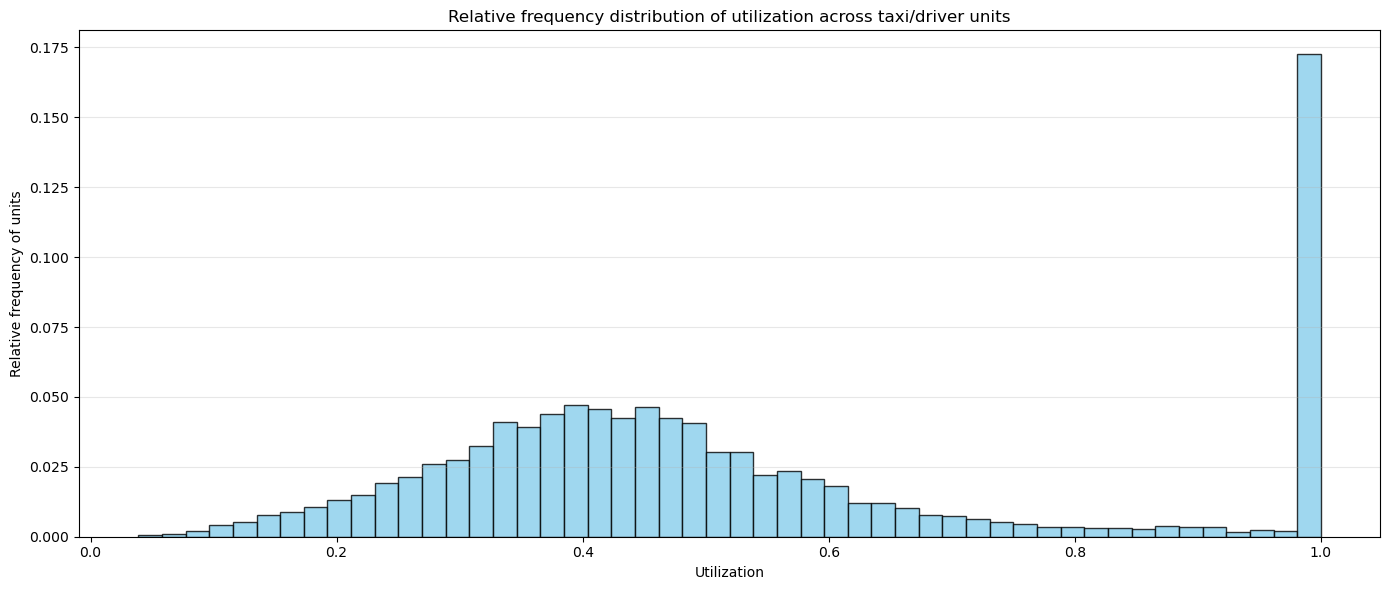

In [29]:
num_unique_pairs = finalDF.select("medallion", "hack_license").distinct().count()
print("Number of unique pairs taxi/driver:", num_unique_pairs)

import numpy as np
import matplotlib.pyplot as plt

unique_pairs_pdf = query1.select("medallion", "hack_license", "utilization", "trips") \
                         .orderBy(F.col("utilization")) \
                         .toPandas()

print("Number of unique taxi/driver units:", len(unique_pairs_pdf))
print("Utilization sample (head):")
print(unique_pairs_pdf['utilization'].head())

weights = np.ones(len(unique_pairs_pdf)) / len(unique_pairs_pdf)

plt.figure(figsize=(14,6))
n, bins, patches = plt.hist(unique_pairs_pdf['utilization'],
         bins=50,
         weights=weights,
         alpha=0.8,
         color='skyblue',
         edgecolor='black')

plt.xlabel("Utilization")
plt.ylabel("Relative frequency of units")
plt.title("Relative frequency distribution of utilization across taxi/driver units")
plt.grid(axis='y', alpha=0.3)

median_val = unique_pairs_pdf['utilization'].median()

frac_eq1 = (unique_pairs_pdf['utilization'] >= 0.9999).mean()   # fraction with utilization ~= 1
frac_03_05 = ((unique_pairs_pdf['utilization'] >= 0.3) & (unique_pairs_pdf['utilization'] <= 0.5)).mean()

print(f"Fraction of units with utilization ≈ 1: {frac_eq1:.4f} ({frac_eq1*100:.2f}%)")
print(f"Fraction of units with utilization in [0.3, 0.5]: {frac_03_05:.4f} ({frac_03_05*100:.2f}%)")

plt.tight_layout()
plt.savefig("utilization_relative_hist.png", dpi=200)
plt.show()

Timeline of occupied and idle periods

In [30]:
util_df = query1.toPandas()
pdf_sel = finalDF.toPandas()

util_df["unit_id"] = util_df["medallion"].astype(str) + "_" + util_df["hack_license"].astype(str)
pdf_sel["unit_id"] = pdf_sel["medallion"].astype(str) + "_" + pdf_sel["hack_license"].astype(str)

util_sorted = util_df.sort_values("utilization").reset_index(drop=True)

selected_units = [
    util_sorted.iloc[0]["unit_id"], # Bottom
    util_sorted.iloc[len(util_sorted)//2]["unit_id"], # Median
    util_sorted.iloc[-1]["unit_id"] # Top
]

print("Selected units:", selected_units)

Selected units: ['A9DC75D59E0EA27E1ED328E8BE8CD828_02790A43EDEAAB9BC0B8829A8F2C5FD0', '71CACFBADF9568AAE88A843DB511D172_92DF2DEB5DBC29860B9092EBA8F3A341', 'FFFECF75AB6CC4FF9E8A8B633AB81C26_D81D2A6BD1DFF04666B7F6E1DDDD5ADF']


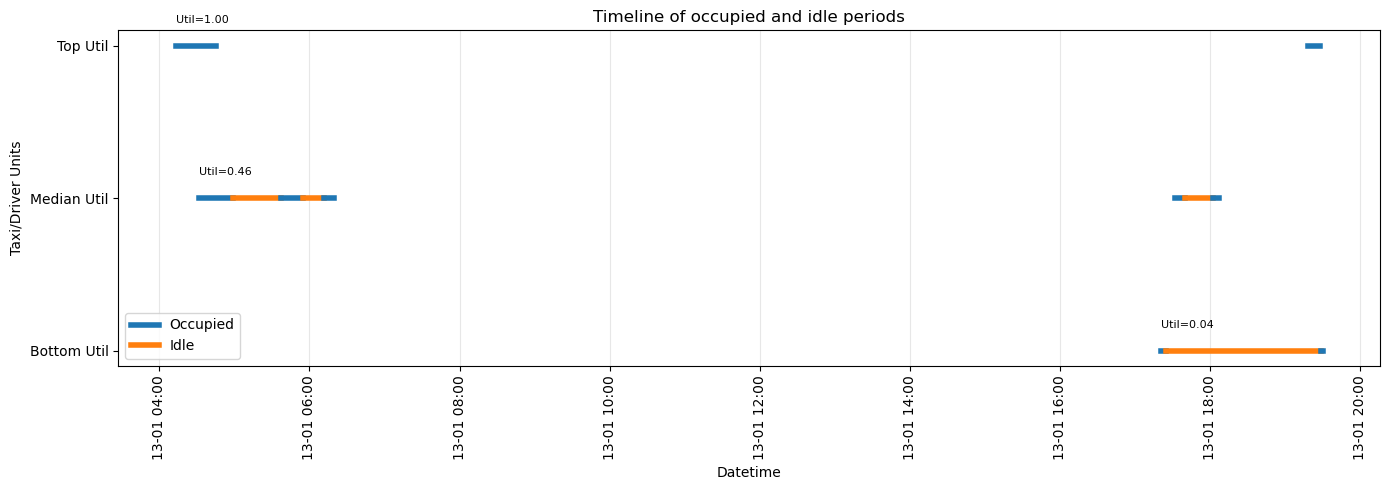

In [31]:
import matplotlib.dates as mdates

MAX_IDLE_MS = 4 * 3600 * 1000

plt.figure(figsize=(14, 5))
unit_positions = {u: i for i, u in enumerate(selected_units)}

for unit in selected_units:
    u_data = pdf_sel[pdf_sel["unit_id"] == unit].sort_values("pickup_timestamp").reset_index(drop=True)
    y = unit_positions[unit]
    
    for i, row in u_data.iterrows():
        plt.plot([row["pickup_timestamp"], row["dropoff_timestamp"]],
                 [y, y],
                 color='tab:blue', linewidth=4, label="Occupied" if i == 0 and y == 0 else "")

        if i < len(u_data) - 1:
            next_pickup = u_data.loc[i+1, "pickup_timestamp"]
            idle_ms = (next_pickup - row["dropoff_timestamp"]).total_seconds() * 1000
            if idle_ms <= MAX_IDLE_MS:
                plt.plot([row["dropoff_timestamp"], next_pickup],
                         [y, y],
                         color='tab:orange', linewidth=4, label="Idle" if i == 0 and y == 0 else "")
    
    util_value = util_df.loc[util_df["unit_id"] == unit, "utilization"].iloc[0]
    plt.text(u_data["pickup_timestamp"].min(), y + 0.15,
             f"Util={util_value:.2f}", fontsize=8) # only the value of utilization

plt.yticks(range(len(selected_units)), ["Bottom Util", "Median Util", "Top Util"])
plt.xlabel("Datetime")
plt.ylabel("Taxi/Driver Units")
plt.title("Timeline of occupied and idle periods")

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=90)

plt.legend(loc="lower left")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

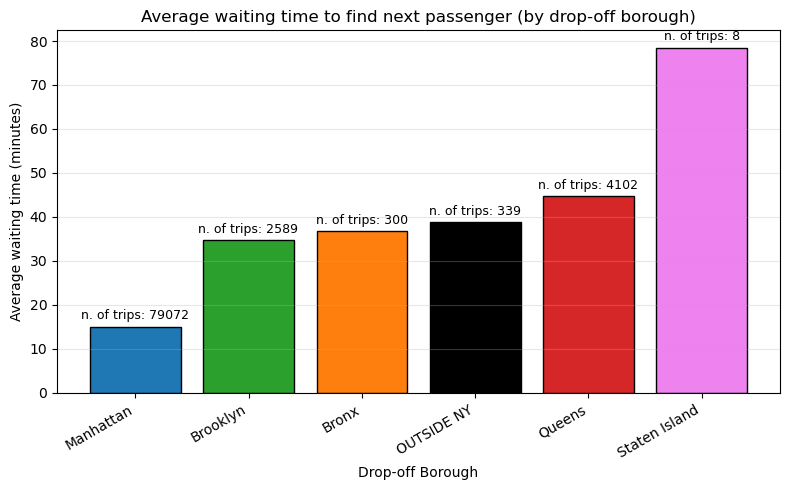

In [32]:
query2_pdf = query2.toPandas()

query2_pdf["avg_wait_min"] = query2_pdf["avg_wait_ms"] / 60000

borough_colors = {
    "Manhattan": "tab:blue",
    "Bronx": "tab:orange",
    "Brooklyn": "tab:green",
    "Queens": "tab:red",
    "Staten Island": "violet",
    "OUTSIDE NY": "black"
}

colors = [borough_colors.get(b, "gray") for b in query2_pdf["dropoff_borough"]]

plt.figure(figsize=(8, 5))
bars = plt.bar(
    query2_pdf["dropoff_borough"],
    query2_pdf["avg_wait_min"],
    color=colors,
    edgecolor="black"
)

for bar, n in zip(bars, query2_pdf["n_trips"]):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 1,
        f"n. of trips: {n}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )

plt.title("Average waiting time to find next passenger (by drop-off borough)")
plt.xlabel("Drop-off Borough")
plt.ylabel("Average waiting time (minutes)")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

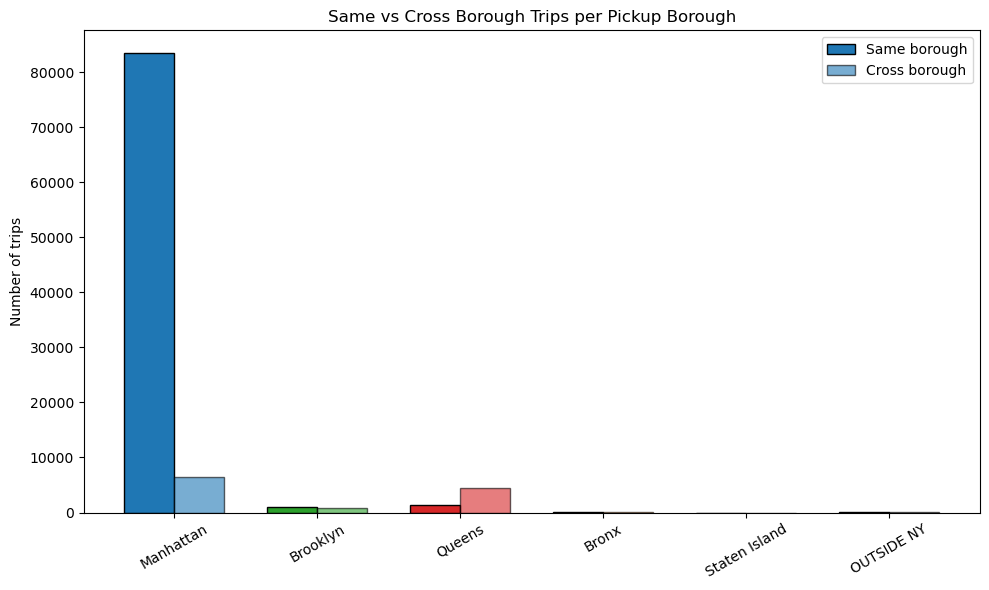

In [33]:
q3 = query3.toPandas().rename(columns={
    "count_same_borough": "count",
    "perc_over_total_trips": "perc"
})
q3["type"] = "Same borough"

q4 = query4.toPandas().rename(columns={
    "count_cross_borough": "count",
    "perc_over_total_trips": "perc"
})
q4["type"] = "Cross borough"

df_bar = pd.concat([q3, q4])

borough_order = ["Manhattan", "Brooklyn", "Queens", "Bronx", "Staten Island", "OUTSIDE NY"]
color_map = {
    "Manhattan": "#1f77b4",     # blu
    "Bronx": "#ff7f0e",         # arancione
    "Brooklyn": "#2ca02c",      # verde
    "Queens": "#d62728",        # rosso
    "Staten Island": "#9467bd", # viola
    "OUTSIDE NY": "#000000"     # nero
}

plt.figure(figsize=(10,6))
bar_width = 0.35
boroughs = df_bar["pickup_borough"].unique()

pivot_df = df_bar.pivot(index="pickup_borough", columns="type", values="count").reindex(borough_order)

x = np.arange(len(pivot_df.index))
plt.bar(x - bar_width/2, pivot_df["Same borough"], width=bar_width,
        color=[color_map.get(b, "#7f7f7f") for b in pivot_df.index],
        edgecolor='black', label="Same borough")

plt.bar(x + bar_width/2, pivot_df["Cross borough"], width=bar_width,
        color=[color_map.get(b, "#7f7f7f") for b in pivot_df.index],
        edgecolor='black', alpha=0.6, label="Cross borough")

plt.xticks(x, pivot_df.index, rotation=30)
plt.ylabel("Number of trips")
plt.title("Same vs Cross Borough Trips per Pickup Borough")
plt.legend()
plt.tight_layout()
plt.show()

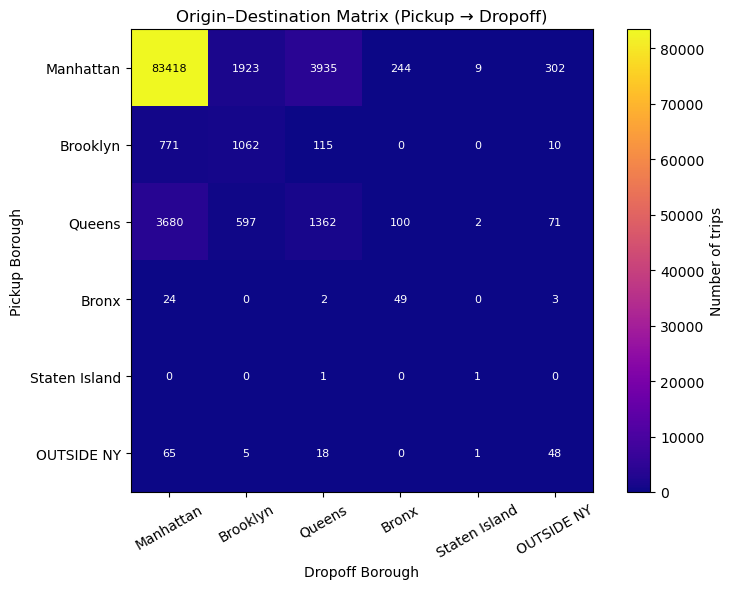

In [34]:
od_counts = (finalDF
    .groupBy("pickup_borough", "dropoff_borough")
    .count()
    .toPandas()
)

od_matrix = od_counts.pivot(index="pickup_borough", columns="dropoff_borough", values="count").fillna(0)
od_matrix = od_matrix.reindex(index=borough_order, columns=borough_order)

plt.figure(figsize=(8,6))
im = plt.imshow(od_matrix, cmap="plasma")

plt.title("Origin–Destination Matrix (Pickup → Dropoff)")
plt.xlabel("Dropoff Borough")
plt.ylabel("Pickup Borough")

vmin, vmax = im.get_clim()
for i in range(len(od_matrix.index)):
    for j in range(len(od_matrix.columns)):
        value = od_matrix.iloc[i, j]
        # normalize to determine how "light" the cell is
        norm_val = (value - vmin) / (vmax - vmin)
        text_color = 'black' if norm_val > 0.7 else 'white'
        plt.text(j, i, int(value), ha='center', va='center', color=text_color, fontsize=8)

plt.xticks(range(len(od_matrix.columns)), od_matrix.columns, rotation=30)
plt.yticks(range(len(od_matrix.index)), od_matrix.index)
plt.colorbar(im, label="Number of trips")
plt.tight_layout()
plt.show()